In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# helper methods

In [2]:
def balance(y):
    print('Class 0:', len(y[y == 0]))
    print('Class 1:', len(y[y == 1]))

In [3]:
def scale(df):
    scaler = StandardScaler().fit(df.drop('y', axis=1))
    scaled_data = scaler.transform(df.drop('y', axis=1))
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns[1:])
    scaled_df.insert(0, 'y', df['y'])
    return scaled_df

In [4]:
def pca(X, y):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['y'] = y

    plt.figure(figsize=(8, 6))
    plt.scatter(pca_df[pca_df['y'] == 0]['PC1'], pca_df[pca_df['y'] == 0]['PC2'], label='No Delirium', alpha=0.5)
    plt.scatter(pca_df[pca_df['y'] == 1]['PC1'], pca_df[pca_df['y'] == 1]['PC2'], label='Delirium', alpha=0.5, marker='x')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Resampled Dataset')
    plt.legend()
    plt.show()

In [5]:
def pca_with_outliers(X, y, mask):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['y'] = y
    pca_df['outlier'] = ~mask  # Mark outliers

    plt.figure(figsize=(8, 6))

    # Plot non-outliers
    plt.scatter(pca_df[(pca_df['y'] == 0) & (pca_df['outlier'] == False)]['PC1'],
                pca_df[(pca_df['y'] == 0) & (pca_df['outlier'] == False)]['PC2'],
                label='No Delirium', alpha=0.5)
    plt.scatter(pca_df[(pca_df['y'] == 1) & (pca_df['outlier'] == False)]['PC1'],
                pca_df[(pca_df['y'] == 1) & (pca_df['outlier'] == False)]['PC2'],
                label='Delirium', alpha=0.5, marker='x')

    # Highlight outliers of class 0 (No Delirium) in red dots
    plt.scatter(pca_df[(pca_df['y'] == 0) & (pca_df['outlier'])]['PC1'],
                pca_df[(pca_df['y'] == 0) & (pca_df['outlier'])]['PC2'],
                color='red', alpha=0.7, edgecolors='k', label='Outliers (No Delirium)')

    # Highlight outliers of class 1 (Delirium) in red crosses
    plt.scatter(pca_df[(pca_df['y'] == 1) & (pca_df['outlier'])]['PC1'],
                pca_df[(pca_df['y'] == 1) & (pca_df['outlier'])]['PC2'],
                color='red', alpha=0.7, edgecolors='k', marker='x', label='Outliers (Delirium)')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Resampled Dataset with Outliers Highlighted')
    plt.legend()
    plt.show()

In [6]:
def outliers(df, contamination=0.05):
    iso = IsolationForest(contamination=contamination)
    yhat = iso.fit_predict(df.drop('y', axis=1).values)
    mask = yhat != -1
    return mask

# load dataset and explore

In [7]:
df = pd.read_csv('dataset/top12.csv')
df.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
0,0,159,65,3,1291,14,39,79,731,5.3,62.7,0.0,21.0
1,0,25,42,3,300,1,13,26,347,0.9,53.5,0.4,6.6
2,0,113,23,3,746,1,13,26,256,3.1,54.3,0.0,15.5
3,0,33,34,3,760,1,13,26,579,12.2,48.3,0.0,16.7
4,0,215,57,3,1518,17,24,67,2376,16.9,34.7,0.0,23.4


In [8]:
df = scale(df)
X = df.drop('y', axis=1).values
y = df['y'].values

Class 0: 20
Class 1: 34


/var/folders/40/2nsl__yd3gz21y383txq3hzm0000gn/T/ipykernel_8624/3725062711.py:24: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pca_df[(pca_df['y'] == 1) & (pca_df['outlier'])]['PC1'],


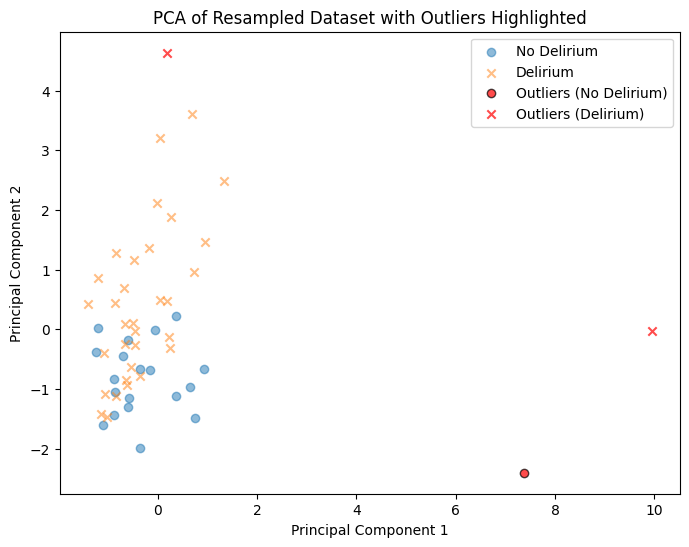

In [9]:
balance(y)
mask = outliers(df)
pca_with_outliers(X, y, mask)

# remove the crazy outliers 

In [10]:
df = df[mask].copy()
X = df.drop('y', axis=1).values
y = df['y'].values

Class 0: 19
Class 1: 32


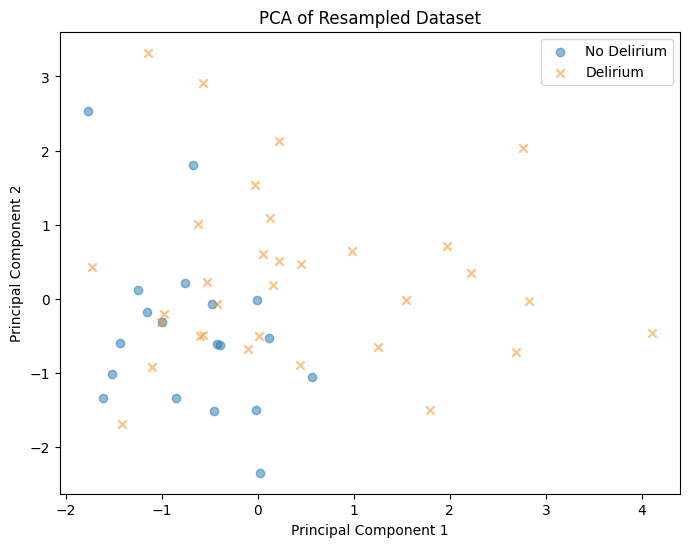

In [11]:
balance(y)
pca(X, y)

# add gaussian noise to round up

In [12]:
def add_gaussian_noise(df, std_dev=1.0):
    y = df['y']
    features = df.drop('y', axis=1)
    noise = np.random.normal(0, std_dev, features.shape)
    noisy_features = features + noise
    noisy_df = pd.DataFrame(noisy_features, columns=features.columns, index=df.index)
    noisy_df.insert(0, 'y', y)
    return noisy_df

In [13]:
dfn = add_gaussian_noise(df)
dfn = dfn.drop(dfn.index[:2])
dfc = pd.concat([df, dfn])

# augment with a vae

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [15]:
X = dfc.drop('y', axis=1).values
y = dfc['y'].values
Xpos, Xneg = X[y == 1], X[y == 0]
Xpos_tensor = torch.tensor(Xpos, dtype=torch.float32)
Xneg_tensor = torch.tensor(Xneg, dtype=torch.float32)
datasetpos = TensorDataset(Xpos_tensor)
datasetneg = TensorDataset(Xneg_tensor)
dataloaderpos = DataLoader(datasetpos, batch_size=10, shuffle=True)
dataloaderneg = DataLoader(datasetneg, batch_size=10, shuffle=True)

In [16]:
class BetaVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, beta=0.8):
        super(BetaVAE, self).__init__()
        self.beta = beta
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3_mean = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc3_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        # Decoder
        self.fc4 = nn.Linear(latent_dim, hidden_dim // 2)
        self.fc5 = nn.Linear(hidden_dim // 2, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        return self.fc3_mean(h2), self.fc3_logvar(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h4 = torch.relu(self.fc4(z))
        h5 = torch.relu(self.fc5(h4))
        return self.fc6(h5)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + self.beta * KLD

In [17]:
def train(model, dataloader, optimizer, num_epochs=2000):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in dataloader:
            data = batch[0]
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = model.loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        avg_loss = train_loss / len(dataloader)  # Average loss per batch
        print(f'Epoch {epoch + 1}, Loss: {avg_loss:.2f}', end='\r')

In [18]:
input_dim = X.shape[1]
hidden_dim = 256
latent_dim = 64
modelpos = BetaVAE(input_dim, hidden_dim, latent_dim)
modelneg = BetaVAE(input_dim, hidden_dim, latent_dim)
optimizerpos = optim.Adam(modelpos.parameters(), lr=1e-3)
optimizerneg = optim.Adam(modelneg.parameters(), lr=1e-3)

In [19]:
train(modelpos, dataloaderpos, optimizerpos, num_epochs=5000)

In [20]:
train(modelneg, dataloaderneg, optimizerneg, num_epochs=5000)

In [21]:
modelpos.eval()
with torch.no_grad():
    zpos = torch.randn(450, latent_dim)
    samplespos = modelpos.decode(zpos).numpy()

In [22]:
modelneg.eval()
with torch.no_grad():
    zneg = torch.randn(450, latent_dim)
    samplesneg = modelneg.decode(zneg).numpy()

In [23]:
# make a single df from samples0 and samples1 where y=0 and y=1 respectively
samplespos_df = pd.DataFrame(data=samplespos, columns=dfn.columns[1:])
samplespos_df.insert(0, 'y', 1)
samplesneg_df = pd.DataFrame(data=samplesneg, columns=dfn.columns[1:])
samplesneg_df.insert(0, 'y', 0)
dfvae = pd.concat([samplespos_df, samplesneg_df], ignore_index=True)

Class 0: 450
Class 1: 450


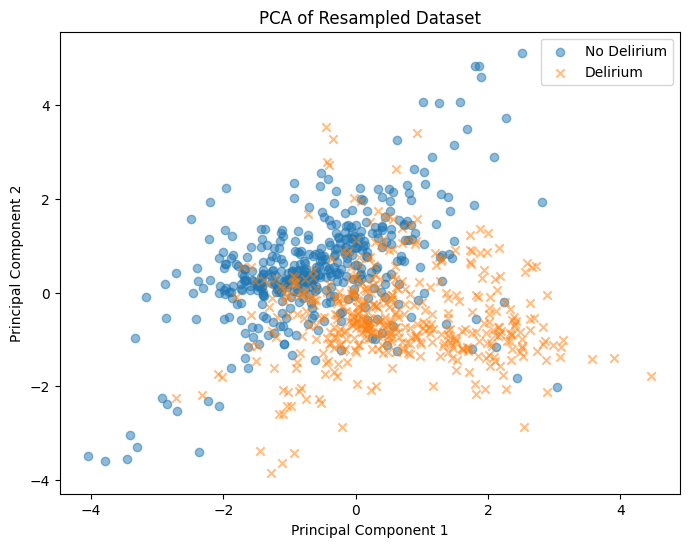

In [24]:
Xvae = dfvae.drop('y', axis=1).values
yvae = dfvae['y'].values
balance(yvae)
pca(Xvae, yvae)

# save all to file

In [25]:
dfa = pd.concat([dfn, dfvae])
len(dfa)

949

In [27]:
# save dfn to file
dfn.to_csv('dataset/noisy.csv', index=False)
dfvae.to_csv('dataset/vae.csv', index=False)
dfa.to_csv('dataset/augmented.csv', index=False)
df.to_csv('dataset/top12-no-outliers.csv', index=False)